# IMDB Movie Review Sentiment Analysis

## 1.1 Data Loading and Preprocessing

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


In [2]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hcwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hcwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hcwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
df = pd.read_csv("data/IMDB Dataset.csv")
print(f"The size of IMDB review data is {df.shape}." )

The size of IMDB review data is (50000, 2).


In [4]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
for col in df.columns:
    print(f"Column {col} has {df[col].isna().sum()} missing values.")

Column review has 0 missing values.
Column sentiment has 0 missing values.


In [7]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

The positive/negative class is balanced. 

## 1.2 Data Cleaning

I will perform the following:
- Remove Noise: URLs, mentions (@username), hashtags (optional), special characters, numbers.
- Case Normalization: Convert text to lowercase.
- Remove Stopwords: Common words that may not contribute to sentiment.
- Stemming/Lemmatization: Reduce words to their base form.

In [8]:
slang = pd.read_csv('data/slang.txt', sep='\t', names=['keyword', 'description'])
genz_slang = pd.read_csv('data/genz_slang.csv', index_col='keyword')
slang_dict = pd.concat([slang, genz_slang]).to_dict()

In [9]:
# Define preprocessing function
def preprocess(text):
    # Remove URLs (http, https, www)
    text = re.sub(r'http\S+|www\S+|\S+\.\S+/\S*', '', text)
    # Remove HTML-like tags (anything between < and >)
    text = re.sub(r'<.*?>', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+|@ \w+', '', text)
    # Remove any single character repeated more than 5 times
    text = re.sub(r'(\w)\1{5,}', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    # Remove extra whitespace after cleaning
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenize
    tokens = word_tokenize(text)
    # Translate slangs and Generation Z slangs
    tokens = [slang_dict.get(word, word) for word in tokens]
    # Convert tokens to lowercase
    tokens = [word.lower() for word in tokens if isinstance(word, str)]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)


In [10]:
# temp_df = df.head(1000)
# # Apply preprocessing
# temp_df['Clean_review'] = temp_df['review'].apply(preprocess)

In [11]:
# # Apply preprocessing
# df['Clean_review'] = df['review'].apply(preprocess)

# df.to_csv("data/cleaned_IMDB_dataset.csv", index=False)

In [12]:
df = pd.read_csv("data/cleaned_IMDB_dataset.csv")
df.head()

,review,sentiment,Clean_review
0,One of the other reviewers has mentioned that ...,positive,one review mention watch oz episod hook right ...
1,A wonderful little production. <br /><br />The...,positive,wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,positive,thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...


## 2 Exploratory Data Analysis (EDA)

<Axes: xlabel='sentiment'>

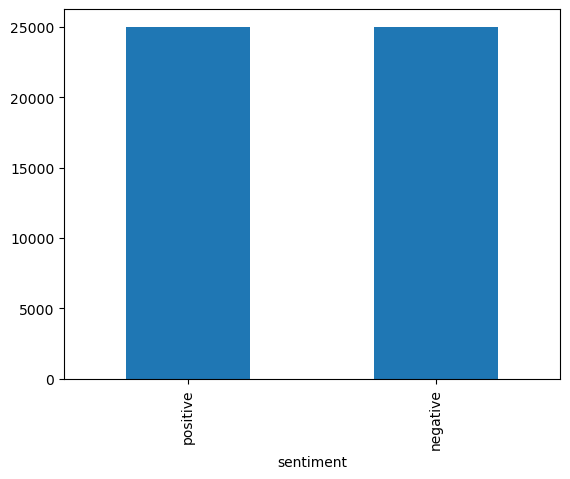

In [13]:
class_distribution = df['sentiment'].value_counts()
# Class distribution
class_distribution.plot(x='index', kind='bar')

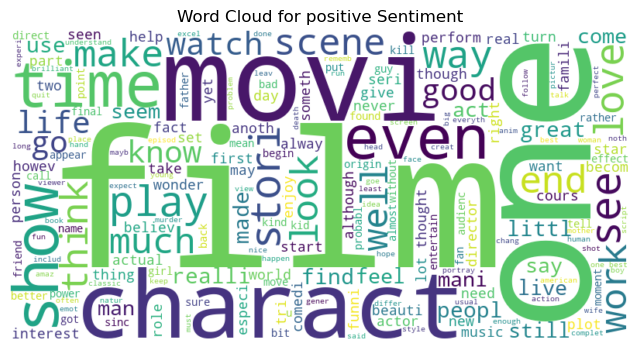

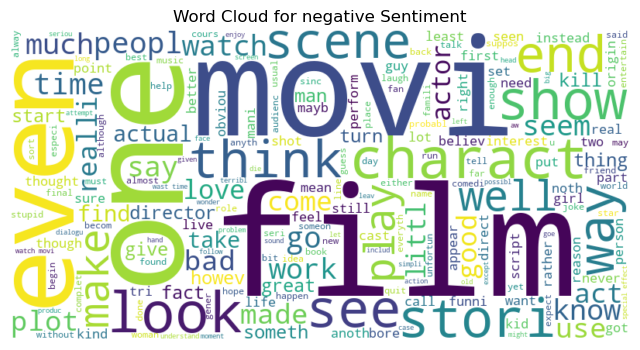

In [14]:
for sentiment in class_distribution.index:
    text = df[df['sentiment']==sentiment]['Clean_review'].to_list()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate("".join(text))
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()
    

Looks like there are a lot of common words such as "film", "movie", "show" that don't convey sentiment. Let me take a look at the weights of these words at the end. 

## 3. Model Training and Fine-tuning

### 3.1 Spliting the train-test dataset.

In [15]:
X = df['Clean_review']
y = df['sentiment']

# Train-test split the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=123)
X_train.shape, y_test.shape

((40000,), (10000,))

### 3.1 Bag of Words:

In [16]:
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train).toarray()
X_test_bow = vectorizer.transform(X_test).toarray()

X_train_bow.shape

(40000, 64016)

### 3.2 Label Encoding
Convert sentiment labesl into numerical format.

In [17]:
# Transforming sentiment to numerical values 0 and 1. 
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Get a sense of the labels
encoder.transform(['negative', 'positive'])

array([0, 1])

## 3.3 Model Selection and Training

Choose appropriate algorithms for sentiment classification.

a. Traditional Machine Learning Models

    Logistic Regression

    Support Vector Machines (SVM)

    Random Forests

    Naive Bayes

b. Deep Learning Models

    Recurrent Neural Networks (RNNs)

    Long Short-Term Memory (LSTM) Networks

    BERT and Transformer-based Models


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123),
    'SVM': SVC(kernel='linear', random_state=123),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=123)
}

# Initialize a dictionary to store results
model_results = {}

# Train each model and evaluate performance
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Fit the model
    model.fit(X_train_bow, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train_bow)
    y_pred_test = model.predict(X_test_bow)
    
    # Evaluate performance
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    
    # Store results
    model_results[model_name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
    
    # Print the confusion matrix
    print(f"Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred_test))

# Display results for all models
pd.DataFrame(model_results).T

Training Logistic Regression...


: 

### 4.2 Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid = GridSearchCV(LogisticRegression(max_iter=1000), parameters, cv=5, scoring='f1')
grid.fit(X_train, y_train)
print(grid.best_params_)
best_model = grid.best_estimator_


## 5. Model Evaluation

Assess model’s performance using appropriate metrics.

a. Metrics to Consider

    Accuracy: Overall correctness.
    Precision: Correct positive predictions.
    Recall (Sensitivity): Ability to find all positive instances.
    F1-Score: Harmonic mean of precision and recall.
    Confusion Matrix: Detailed breakdown of predictions.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
print(f'Cross-Validation F1 Scores: {scores}')
print(f'Mean F1 Score: {scores.mean()}')

## 6. Model Serialization

In [ ]:
import joblib

# Save the model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')
